<a href="https://www.assemblyai.com/">
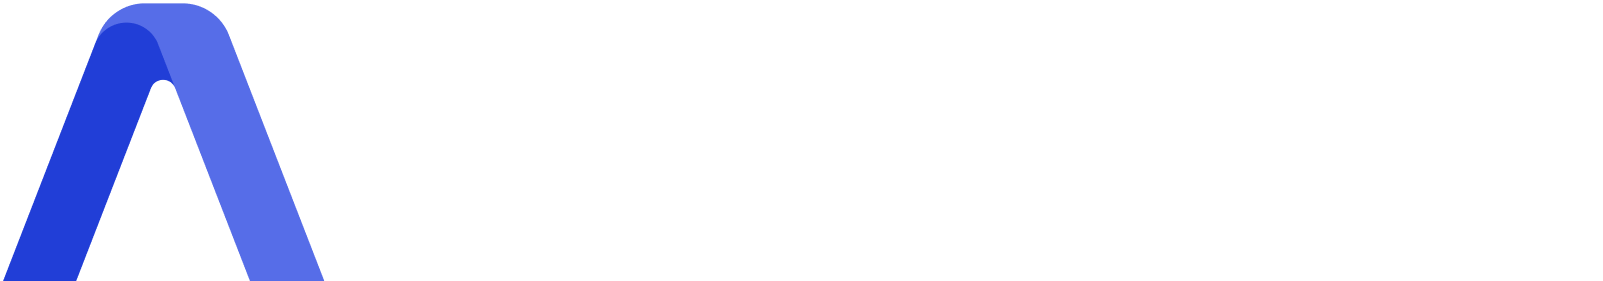
</a>
</img>

Welcome to the **AssemblyAI LeMUR Quickstart Guide**!

This Colab notebook will get you up-and-running using [LeMUR](#https://www.assemblyai.com/blog/lemur/) via our API so you can start building generative AI-powered features. If you want to try out LeMUR in a no-code fashion, try taking a look at our [Playground](https://www.assemblyai.com/playground/v2).



# Setup

To get started, paste your API token into the empty string below. If you don't already have an API token, you can get one for free [here](https://www.assemblyai.com/dashboard/signup). You'll need to set up billing to use LeMUR.

In [ ]:
API_TOKEN = "your-token-here"

**Make sure not to share this token with anyone** - it is a private key associated uniquely to your account.

Next, we'll install the AssemblyAI Python SDK, which will allow us to easily use LeMUR in just a few lines of code.

In [ ]:
%pip install "assemblyai>=0.15" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


Finally, import the `assemblyai` package and set your API token in the settings:

In [ ]:
import assemblyai as aai

# set the API key
aai.settings.api_key = f"{API_TOKEN}"

# Getting started with LeMUR

To get started using LeMUR, we'll need a **transcript** (or a group of transcripts) to analyze. The AssemblyAI Python SDK makes it easy to generate a transcript in just a few lines of code.

To obtain our `transcript`, we instantiate an `aai.Transcriber()`, and then use it to transcribe a file on the internet. The file is a [video recording](https://www.youtube.com/watch?v=qGFoZ8yodc4) of an Engineering Key Review meeting.


In [ ]:
transcriber = aai.Transcriber()

transcript = transcriber.transcribe("https://storage.googleapis.com/aai-web-samples/meeting.mp4")

if transcript.error:
  print(transcript.error)

Every transcription you create with AssemblyAI has a unique **transcript ID**, which you can access through the `id` attribute of a `Transcript` object:

In [ ]:
transcript.id

In the future, if you would like to further analyze this file with LeMUR, you can do so without transcribing the file again. Instead, you can simply fetch the transcript you already created by using its ID:

In [ ]:
transcript_from_id = aai.Transcript.get_by_id("TRANSCRIPT_ID")

You can find a list of your previous transcripts and their IDs in your [dashboard](https://www.assemblyai.com/app/processing-queue).

**Now that we have our `transcript`, we can analyze it with LeMUR**. LeMUR has dedicated endpoints for 3 special tasks:

1. Custom Summary
2. Question Answering
3. Action Items

LeMUR additionally has a `task` endpoint, that allows you to create your own custom tasks for LeMUR to handle. We can use LeMUR for any of these tasks through the `lemur` attribute of our `transcript`.

In [ ]:
[i for i in dir(transcript.lemur) if not i.startswith('_')]

['action_items', 'question', 'summarize', 'task']

 Let's take a look at how to use LeMUR for each of these capabilities in turn.

## Custom Summary

The **Custom Summary** endpoint allows us to write a summary of the transcript that is aligned with the user's requested format and context. Let's take a look at how to obtain a Custom Summary from LeMUR for the meeting we transcribed above.

When making a custom summary, we can pass in several optional parameters. The first is `context`, which provides us the opportunity to pass contextualizing information to LeMUR in order to help it formulate a Custom Summary.

In [ ]:
context = "A GitLab meeting to discuss logistics"

A second optional parameter is `answer_format`, which allows us to specify an answer format that the summary should adhere to. For example, we could request a [markdown](https://en.wikipedia.org/wiki/Markdown)-formatted response, where each topic of discussion in the meeting is bolded with a summary of the corresponding discussion directly below it.

In [ ]:
answer_format = '''**<topic header>**
<topic summary>
'''

We use the `lemur.summarize` method of the `transcript` to create a Custom Summary, passing in our `context` and `answer_format` as arguments:

In [ ]:
result = transcript.lemur.summarize(
  context=context,
  answer_format=answer_format,
)

In [ ]:
print(result.response)


 **Engineering Key Review**
The meeting begins with a proposal to break up the engineering key review meeting into four departmental key reviews to allow for more in-depth discussion. A two-month rotation is suggested so as not to add too many new meetings. The proposal is supported.

**R&D Merge Request Rates**
There is discussion around the R&D overall and wider merge request rates. It is clarified that the wider rate includes community contributions while the overall rate includes internal and external requests. There is agreement to track the percentage of total requests from the community over time instead.

**Postgres Replication Issue**
There is an update on work to address lag in Postgres replication for the data engineering team. Actions include dedicating a host for the data team, database tuning, and improving demand on the database. More work is needed to determine the best solutions. An update will be provided at the next infrastructure key review.

**Defect Tracking and 

## Question Answering

The Question Answering endpoint allows you to ask questions about the contents of a transcript or a group of transcripts.

To define the questions we use the `LemurQuestion` class. Each `LemurQuestion` takes a `question` argument that contains the text of the question itself. Additionally, each `LemurQuestion` has three optional parameters:

1. `context` - provides wider context to the model
1. `answer_format` - specifies a format to return the answer in (e.g. `"bullet points"`, `"short sentence"`). Cannot be used with `answer_options`.
1. `answer_options` - specifies a list of discrete options to return (e.g. `["High", "Medium", "Low"]`). Cannot be used with `answer_format`.

We'll ask LeMUR to answer two questions. For the first question, we specify an `answer_format`, and for the second question we specify the possible `answer_options`:

In [ ]:
questions = [
    aai.LemurQuestion(
        question="What are the top level KPIs for engineering?",
        answer_format="short sentence"),
    aai.LemurQuestion(
        question="How many days has it been since the data team has gotten updated metrics?",
        answer_options=[1, 2, 3, 4, 5, 6, 7, "more than 7"]),
]

We use the `lemur.question` method of the `transcript` to ask our questions, passing `questions` in as an argument:

In [ ]:
result = transcript.lemur.question(questions)

for q in result.response:
    print(f"Question: {q.question}")
    print(f"Answer: {q.answer}")

Question: What are the top level KPIs for engineering?
Answer: The top level KPIs for engineering are R&D overall MR rate and R&D wider MR rate.
Question: How many days has it been since the data team has gotten updated metrics?
Answer: 4


We can see that LeMUR correctly answered the two questions - the first is answered at around the [1:45](https://www.youtube.com/watch?v=qGFoZ8yodc4&t=105s) mark in the video, and the second answered around the [9:05](https://www.youtube.com/watch?v=qGFoZ8yodc4&t=545s) mark.

Note: currently, a maximum of 4,000 tokens can be generated by LeMUR at once, so if you are expecting long responses it will be safer to ask questions in different requests where possible.

## Action Items

The Action Items endpoint allows you to automatically generate a list of action items. For this, we use the `lemur.action_items` method.

We can provide optional `context` and `answer_format` parameters, as we saw above for Custom Summary.

In [ ]:
result = transcript.lemur.action_items(
    context="A GitLab meeting to discuss logistics",
    answer_format="**<topic header>**\n<relevant action items>\n",
)

print(result.response)


 **Metrics**
Review and improve metrics for measuring bug severity and age. Look into measuring percentage of open bugs within SLO rather than closed bugs.

**Database Performance**
Investigate database performance issues and work with infrastructure team to address. Consider dedicated host, tuning improvements and reducing overall demand. Provide update at next infra key review.

**Narrow MR Rate**
Monitor narrow MR rate and look for rebound in March. Hold steady at target of 10 going forward and focus on improving other metrics like quality, security and availability. 

**Customer Satisfaction**
Continue monitoring customer satisfaction score and work to improve. Recent decline was smallest in several quarters which is optimistic, but more data needed to confirm upward trend.

**Prioritizing Security Work** 
Work with teams to improve prioritizing and measuring security work. Current metrics do not adequately reflect security work being done.

**Vacation and Time Off**
Be aware of a

## Custom Task

Finally, LeMUR has the ability to complete custom tasks through the Task endpoint, which can be access through the `lemur.task` method. Users should adhere to good prompting practices for best results - since these tasks are arbitrary, LeMUR has no way of automatically preparing inputs for the given task as it does with Custom Summary, Question Answering, and Action items.

In [ ]:
result = transcript.lemur.task(
  "You are a helpful coach. Provide an analysis of the transcript "
  "and offer areas to improve with exact quotes. Include no preamble. "
  "Start with an overall summary then get into the examples with feedback. "
  "Under each example, place the corresponding feedback in a bulleted list.",
)

print(result.response)


 Overall summary: The meeting covers a lot of ground with many metrics and updates. There are opportunities to improve clarity, focus the discussion, and follow up on action items.

Example 1: "So the difference between them in the simplest sense is that R D wider Mr rate includes both community contributions and community Mrs. The problems I see with this are that one, the wider Mr rate, the one that includes internal and external Mrs, it duplicates the overall Mr rate, which is the wider Mr rate should just be external. Right. And then overall should be narrow plus wider, like we say, the wider community. Right. Okay. I&#39;ll have to check the taxonomy. Lily, can you confirm Sid&#39;s reasoning is my understanding as well? Yeah, I believe Water Mr rate just captures community contributions only and no internal."

•Clarify the definitions and metrics upfront to avoid confusion. 
•Come prepared with the correct information.

Example 2: "Did ask I saw that issue and I did talk to Crai

## Analyzing multiple files at once

We saw above how to use LeMUR to analyze a given transcript. LeMUR is also capable of analyzing **groups** of transcripts all together as one unit. Currently, it is possible to **group up to 100 transcripts at a time** (or 100 hours of audio, whichever is lesser).

To analyze multiple files at once, we'll use our `transcriber` to make a **`transcript_group`** composed of three episodes of [World News This Week](https://abcaudio.com/podcasts/world-news-this-week/):

In [ ]:
transcriber = aai.Transcriber()

transcript_group = transcriber.transcribe_group(
    [
        "https://storage.googleapis.com/aai-web-samples/world_news_this_week_2023_06_30.mp3",
        "https://storage.googleapis.com/aai-web-samples/world_news_this_week_2023_07_07.mp3",
        "https://storage.googleapis.com/aai-web-samples/world_news_this_week_2023_07_14.mp3",
    ],
)

From there, we can use LeMUR just as we did above, with the only change being using the `transcript_group` instead of `transcript`:

In [ ]:
result = transcript_group.lemur.summarize(
  context="Weekly world news podcast",
  answer_format="TLDR"
)

print(result.response)


 Here is a TLDR summary of the transcript:

Extreme heat affecting tens of millions across U.S. with flooding and record high temps expected. Vermont experiencing torrential rains, flooding; killed 1, damaged businesses. More rain coming. Actors strike over pay, AI threat. Long Island arrest: 3 counts murder, 3 bodies found decade ago. FDA OKs 1st OTC birth control pill. Iowa passes new abortion limits. Inflation slows: prices up 3% in year. Ed Dept forgiving 800K borrowers’ student debt. Jury: synagogue killer eligible for death. Biden: U.S. won’t waver backing Ukraine. China hackers breached U.S. gov’t Microsoft email. CA rains cause landslides, destroy homes. Ex-Manson cult member paroled after 50+ years for murder. Jury: Aretha Franklin handwritten will stands.


In [ ]:
questions = [
    aai.LemurQuestion(question="What are the most important news events?"),
    aai.LemurQuestion(question="Are there any news events relating to global trade?"),
]

result = transcript_group.lemur.question(questions)

for q in result.response:
    print(f"Question: {q.question}")
    print(f"Answer: {q.answer}")

Question: What are the most important news events?
Answer: The most important news events discussed relate to Supreme Court rulings on student debt relief, affirmative action and a graphic artist's case, as well as the audio recording of Trump discussing classified documents.
Question: Are there any news events relating to global trade?
Answer: No, there are no news events relating to global trade mentioned.


# Prompting 101

For the remainder of this notebook, we'll review the topic of **prompting** so that you can get optimal results when applying LeMUR. Prompting is especially important when [defining your own tasks](#scrollTo=QXCCAuU5scox) using the `lemur.task`.

## What is Prompting?



**Prompting** involves providing clear and well-crafted instructions or questions to Large Language Lodels (LLMs) in order to guide them in generating useful and desirable responses.

## Evolution of Prompting

In early LLMs (prior to instruction fine-tuning), prompting looked very different from how it does now. Because LLMs are “next-word generators”, prompting included providing a foundational preamble to "trick" the LLM into providing a desirable output. Consider the task below:

*The goal is to get the LLM to answer the question "What is the capital of France?"*

Early LLMs would get confused by questions like these, not "understanding" that they should provide an answer to the question. Instead, they would output what they calculated as the most probable sequence of words, usually creating a pattern from what had been provided:

*Prompt:*
```
What is the capital of France?
```
*Response:*
```
What is the capital of Germany?
```

To achieve the correct answer, we would have to "trick" the LLM into answering the question by starting the correct answer for it and then letting it do the rest of the work:

*Prompt:*
```
What is the capital of France? The capital of france is
```
*Response:*
```
Paris
```

Other techniques like few-shot prompting would be used to improve LLMs' performance on tasks like these. Modern LLMs supersede the need for tricks like these finetuning on a series of Questions & Answer pairs. This has enabled LLMs to respond effectively to direct instructions, providing us with the ease of the first prompting method but the desired model behavior of the second prompting method.

We can now prompt like this:

*Prompt:*
```
What is the capital of France?
```
*Response:*
```
Paris
```



## Context Is Key

Context is the additional information/data surrounding a situation or problem that the model does not have by default. In prompt engineering, it guides LLMs on how to generate accurate responses by providing a deeper understanding of the task at hand.


---


When designing prompts for modern LLMs such as those used with LeMUR, **you should speak using simple concise language** and **assume the model has incredible general knowledge** but knows **nothing specific** about your business. For example:

*The goal is to get LeMUR to answer some questions about a phone call*

```
Question: Is this customer a Qualified Sales Lead?
Answer: Yes, this customer mentioned "that sounds interesting" which implies they are an interested buyer and should be a qualified sales lead.
```

This example looks probable but may be correct or incorrect depending on your definition of a Qualified Sales Lead. To improve this ambiguity and tailor the answer to a specific use case we can add some `context`.

```
Question: Is this customer a Qualified Sales Lead?
Context: Qualified Sales Leads have the following criteria:
A budget
A stakeholder with purchasing authority
A timeline

Answer: No, this customer does not meet the criteria of a Qualified Sales Lead.
```

We can further improve this by providing an `answer_format` or `answer_options` parameter.

```
Question: Is this customer a Qualified Sales Lead?
Context: Qualified Sales Leads have the following criteria:
A budget
A stakeholder with purchasing authority
A timeline
Answer_Options: ["Yes", "No"]

Answer: No
```
```
Answer_Format: "<Answer> (<Reason>)"

Answer: No (Didn't mention any of the outlined criteria)
```

Another example using LeMUR Custom Summary could be:

*The goal is to get LeMUR to generate a follow-up Slack post for a recorded team meeting*
```
Answer_Format: "A short paragraph describing the key points of discussion"

Answer: "In this meeting, the team discusses the current status and plan to launch a new product. Morgan mentioned that an external vendor has had an outage which has caused the engineering team to adjust their expected release date. Joshua confirms that the marketing team has everything they need to go live with the launch. The team discusses the new deadline and decides that February 18th is the updated deadline. The team will post these updates in Slack for Jeremy and Jocelyn who could not attend the meeting."
```
This answer is helpful as a generic overview but we may need more specific answers based on our use case.
```
Answer_Format: "<Meeting Title> <Attendees> <Brief Recap of Conversation Topics> <Outcomes> <Next Steps>"
Context: "This is a meeting with Morgan (Engineering Lead), Joshua (Marketing Lead), Alex (Sales Lead), Mary (Social Media Manager), and Josiah (Support Engineer). The purpose of the meeting is to discuss the Launch of feature X."

Answer:
Status Update on Feature X

Attendees:
Morgan (Engineering Lead)
Joshua (Marketing Lead)
Alex (Sales Lead)
Mary (Social Media Manager)
Josiah (Support Engineer)

Morgan mentioned that the engineering deadline has slipped because of a third-party vendor.
Joshua confirms that the Marketing team has finalized all the launch material.

The launch date has been moved to February 18th

Morgan will finalize a contract with a new vendor for redundancy
Mary will reschedule the social media posts to align with the new date.
```

## Writing Good Prompts
A good prompt consists of three key elements:

1. **Clear instruction or specific question**: Clearly state what you want the model to do or the question you want it to answer. Use concise and unambiguous language to ensure the model understands your intent.

2. **Missing information provided as context**: Provide any relevant information or data that the model may need to complete the task or answer the question accurately. Context helps guide the model's understanding and ensures contextually appropriate responses.

3. **Desired output format outlined**: Clearly specify the desired format for the model's response. Whether you need a short paragraph, bullet points, or a specific structure, outlining the desired output format helps the model generate outputs that align with your expectations.

A good prompt is essential for obtaining accurate and relevant outputs from the generative AI model. Follow these guidelines to create effective prompts:

### Providing clear instruction
* **Use action verbs**: Begin prompts with action verbs to guide the model's understanding of the desired action. For example, instead of asking, ```"What are the features of the product?"``` use the prompt, ```"List the key features of the product."```

* **Avoid compound questions/instructions**: Keep your prompts focused on a single task or question. Compound instructions can confuse the model and lead to less accurate outputs. Break down complex tasks into smaller, simpler prompts for better results.

* **Utilize placeholders for structured data and natural language elements**: Incorporate placeholders or variables within your prompts to represent dynamic information. These placeholders can be replaced with specific values during the generation process, making the prompts adaptable to different scenarios.

### Guiding the Model with Context
* **Utilize structured data and natural language**: Combine structured data, such as variables and placeholders, with natural language descriptions to provide comprehensive context to the model. This helps the model understand specific details while maintaining human-like communication.

* **Use common phrases like "Let's think step by step"**: To guide the model's thought process, incorporate common phrases or cues that encourage a step-by-step approach. This can help the model organize its response and provide well-structured information.

* **Embed instructions within the prompt text**: Place the instructions or additional context directly within the prompt text itself. This allows the model to process all the relevant information at once and generate appropriate responses accordingly.

* **Use clear definitions**: Establish specific definitions for terms or structures you want the model to use consistently. For example, define the format for action items as a bullet list to be generated after a call.

```
Question: "Identify action items from the meeting"

Context:
Action items are tasks for the participants to complete after the meeting
```

* **Incorporate Few-Shot Examples**: By incorporating few-shot examples into your prompts, you can fine-tune the model's understanding and improve its ability to provide accurate and contextually relevant responses.

```
Question: "Identify action items from the meeting"

Context:
Action item examples from other meetings:
- "Schedule a follow-up meeting with the client to address their concerns."
- "Review the proposal and provide your feedback by the end of the week."
- "Complete the data analysis and share the results with the team."
```

### Controlling Output from the Model
* **Create templates with variables and definitions**: Construct answer format templates that include predefined variables and definitions. Variables act as placeholders for dynamic information, while definitions establish terminology and structures for consistent responses.

```
Question: "Identify action items from the meeting"

Answer Format:
{
  "assignee": <assignee>,
  "action_item": <action item>,
  "due_date": <due_date>
}
```

# Continued Learning

That's all for this notebook! You can check out some of the resources below for continuing your prompt engineering education.

- [Awesome Prompt Engineering](https://github.com/promptslab/Awesome-Prompt-Engineering)
- [LeMUR API Docs](https://www.assemblyai.com/docs/Models/lemur)

Alternatively, feel free to check out our Blog or YouTube channel to learn about a wide range of content on AI and development

- [Blog](https://www.assemblyai.com/blog)
- [YouTube](https://www.youtube.com/AssemblyAI)